In [65]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import shutil
import pathlib
import matplotlib.pyplot as plt

from shapely.geometry import box

import sys
sys.path.append("../..")

from objectherkenning_openbare_ruimte.frame_extraction import data_helper

In [45]:
N_IMAGES = 20
FPS = 1.0
BUFFER = 50
SAMPLING_WEIGHT = 1.0

In [3]:
decos_df = pd.read_csv("../data/decos/vergunningen_objects_2024-02-17.csv")
decos_gdf = gpd.GeoDataFrame(
    decos_df,
    geometry=gpd.GeoSeries.from_wkb(decos_df.geometrie_locatie),
    crs='EPSG:28992')

In [75]:
metadata = "../data/velotech/sunny_day/14-D17M02Y2024-H21M28S48.csv"
meta_df = data_helper.extract_velotech_metadata_fps(metadata, FPS)

In [76]:
meta_gdf = gpd.GeoDataFrame(
    meta_df,
    geometry = gpd.points_from_xy(
        x = meta_df.gps_lon,
        y = meta_df.gps_lat,
        crs = 'EPSG:4326',
    )

).to_crs('EPSG:28992')
meta_bb = box(*meta_gdf.total_bounds)

In [77]:
decos_area = decos_gdf.clip(meta_bb.buffer(BUFFER)).unary_union.buffer(BUFFER)
meta_gdf["permit"] = meta_gdf.intersects(decos_area)

<Axes: >

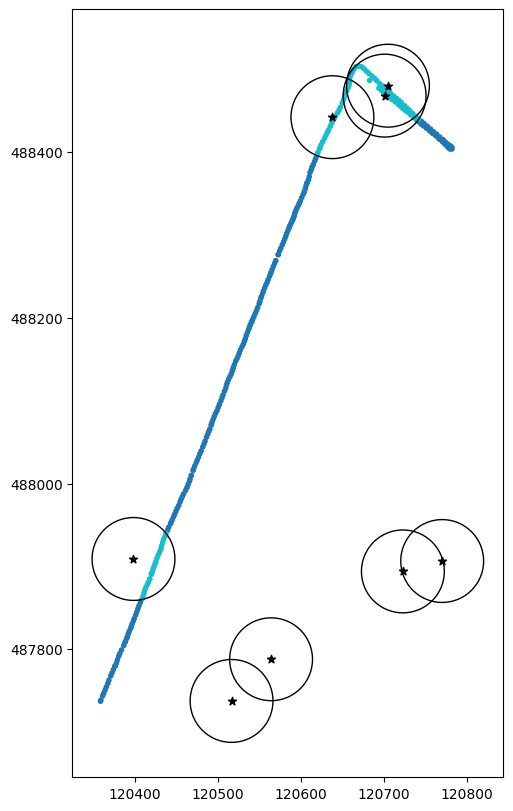

In [78]:
fig, ax = plt.subplots(1, figsize=(8, 8), constrained_layout=True)

meta_gdf.plot(ax=ax, column="permit", marker=".")
decos_gdf.clip(meta_bb).plot(ax=ax, color="black", marker='*')
decos_gdf.clip(meta_bb).buffer(50).plot(ax=ax, facecolor="none", edgecolor='black')

In [79]:

weights = [SAMPLING_WEIGHT if permit else 1-SAMPLING_WEIGHT 
           for permit in meta_gdf.permit]
weights = weights / np.sum(weights)

In [80]:
draw = np.random.choice(np.arange(len(meta_gdf)),
                        N_IMAGES,
                        p=weights)

In [81]:
sample = np.zeros_like(meta_gdf.permit, dtype=bool)
sample[draw] = True
meta_gdf["sample"] = sample

In [82]:
ratio = np.count_nonzero(meta_gdf.permit.iloc[draw]) / len(draw)
print(f"Ratio permit/total: {ratio}")

Ratio permit/total: 1.0


<Axes: >

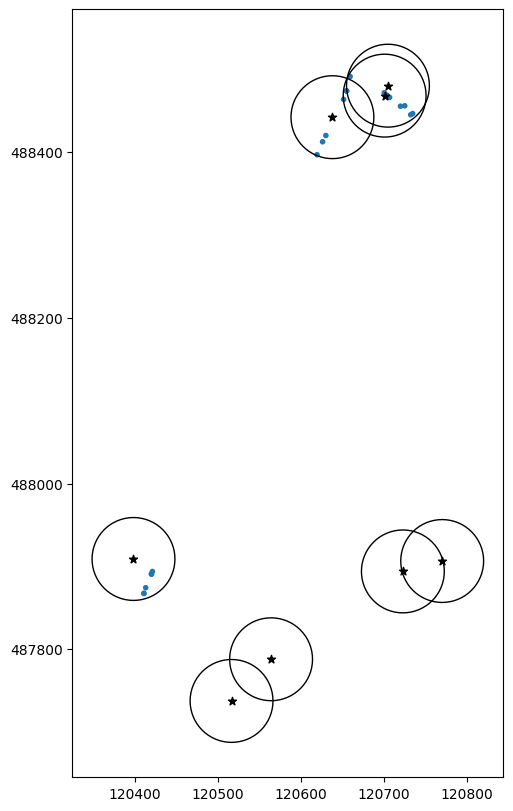

In [83]:
fig, ax = plt.subplots(1, figsize=(8, 8), constrained_layout=True)

meta_gdf.iloc[draw, :].plot(ax=ax, column="permit", marker=".")
decos_gdf.clip(meta_bb).plot(ax=ax, color="black", marker='*')
decos_gdf.clip(meta_bb).buffer(50).plot(ax=ax, facecolor="none", edgecolor='black')

In [51]:
pathlib.Path(f"../data/velotech/frames/keep").mkdir(exist_ok=True, parents=True)

frames = pathlib.Path("../data/velotech/frames/20240410-155030").glob("*.jpg")

for frame in frames:
    frame_nr = int(frame.name.rstrip(".jpg").rsplit(sep="_", maxsplit=1)[-1])
    if frame_nr in draw:
        target_path = f"../data/velotech/frames/keep/{frame.name}"
        # print(f"{frame.as_posix()} => {target_path}")
        shutil.copyfile(frame.as_posix(), target_path)